# Imports

## Libraries

In [1]:
import sys
import time
import math
import itertools


import numpy as np
import pandas as pd


import matplotlib.pyplot as plt


from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.preprocessing import normalize

import torch


import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

## Data

In [2]:
def get_mnist_data(train, download, save):
    if download:

        transform_to_tensor = transforms.Compose([transforms.ToTensor()])

        dataset = torchvision.datasets.MNIST(
            root="./data", train=train, download=True, transform=transform_to_tensor
        )

        dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
        dataiter = iter(dataloader)
        images, labels = next(dataiter)

        images = images.view(images.size(0), -1)  # (batch_size, 28*28)

        images_np = images.numpy()
        labels_np = labels.numpy()
        if save:
            if train:
                np.save("mnist_train.npy", images_np)
                np.save("mnist_train_labels.npy", labels_np)
            else:
                np.save("mnist_test.npy", images_np)
                np.save("mnist_test_labels.npy", labels_np)
    else:
        if train:
            images_np = np.load("mnist_train.npy")
            labels_np = np.load("mnist_train_labels.npy")
        else:
            images_np = np.load("mnist_test.npy")
            labels_np = np.load("mnist_test_labels.npy")

    return images_np, labels_np

In [3]:
images, labels = get_mnist_data(train=True, download=False, save=False)
print(images.shape, labels.shape)

(60000, 784) (60000,)


In [4]:
images_test, labels_test = get_mnist_data(train=False, download=False, save=False)
print(images_test.shape, labels_test.shape)

(10000, 784) (10000,)


## Data processing

In [5]:
pca = PCA(n_components=164, svd_solver="full")
images_pca_test = pca.transform(images_test)

In [6]:
images_pca_normalized = normalize(images_pca, norm="l2", axis=1)
images_pca_test_normalized = normalize(images_pca_test, norm="l2", axis=1)

In [7]:
# images_pca_normalized = images_pca
# images_pca_test_normalized = images_pca_test

In [8]:
print(images_pca_normalized.shape, images_pca_test_normalized.shape)

(60000, 164) (10000, 164)


# Data analysis

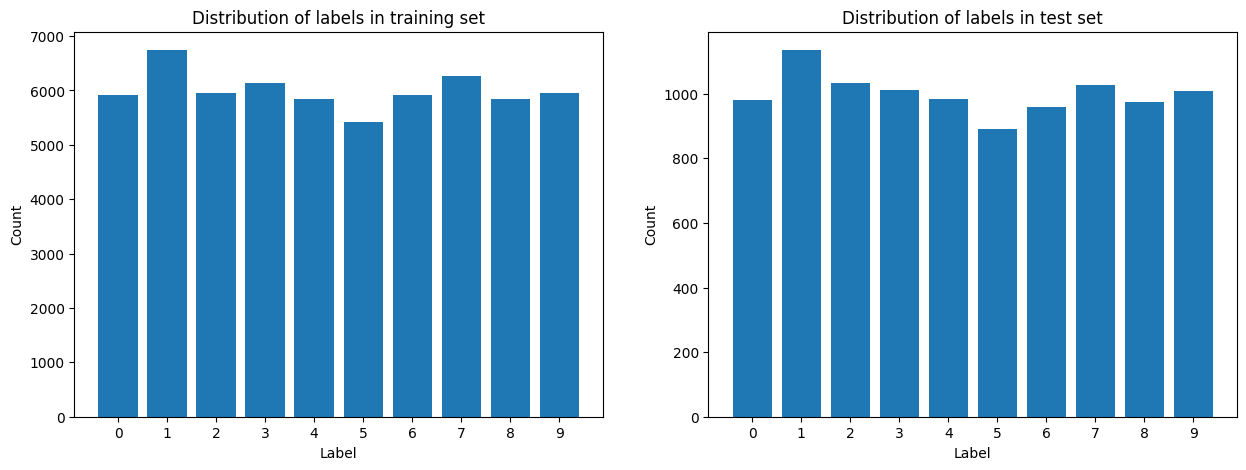

In [9]:
labels_train, counts_train = np.unique(labels, return_counts=True)
labels_test, counts_test = np.unique(labels_test, return_counts=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].bar(labels_train, counts_train)
ax[0].set_title("Distribution of labels in training set")
ax[0].set_xlabel("Label")
ax[0].set_ylabel("Count")
ax[0].set_xticks(labels_train)

ax[1].bar(labels_test, counts_test)
ax[1].set_title("Distribution of labels in test set")
ax[1].set_xlabel("Label")
ax[1].set_ylabel("Count")
ax[1].set_xticks(labels_test)

plt.show()

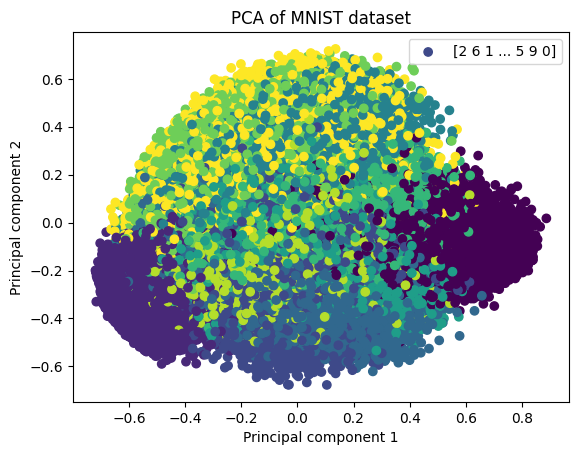

In [10]:
plt.scatter(
    images_pca_normalized[:, 0], images_pca_normalized[:, 1], c=labels, label=labels
)
plt.title("PCA of MNIST dataset")
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
# plt.colorbar()
plt.legend()
plt.show()

C:\Users\louis\AppData\Local\Temp\ipykernel_8376\1853453659.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


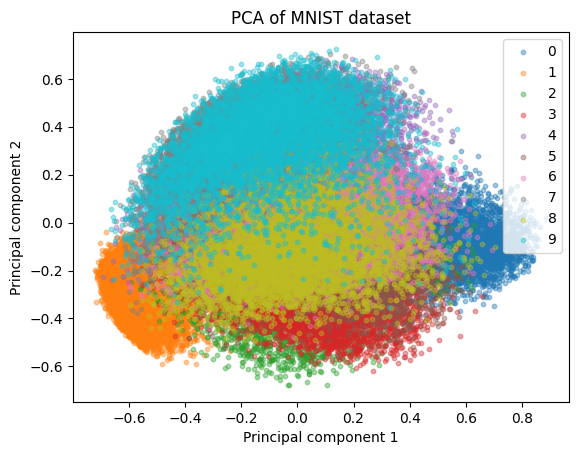

In [11]:
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap("tab10", len(unique_labels))

for i, label in enumerate(unique_labels):
    label_mask = labels == label
    plt.scatter(
        images_pca_normalized[label_mask, 0],
        images_pca_normalized[label_mask, 1],
        c=[colors(i)],
        label=label,
        alpha=0.4,
        s=10,
    )

plt.title("PCA of MNIST dataset")
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.legend()
plt.show()

# Metric Learning

## Defining functions

In [12]:
def distance_metric(a, b, M):
    a = np.array(a)
    b = np.array(b)

    if a.shape != b.shape:
        raise ValueError("x and x_prime must have the same shape.")

    if M is None:
        raise ValueError("M is None")
        M = np.eye(len(a))
    else:
        if M.shape[0] != M.shape[1]:
            raise ValueError("M must be a square matrix.")
        if M.shape[0] != len(a):
            raise ValueError(
                "M must have the same number of rows/columns as the dimensionality of a and b."
            )

    left = np.matrix(a - b)
    right = np.transpose(left)

    return float(left @ M @ right)

In [13]:
def hinge_loss(real_distance, distance_predicted, b):
    if b < 0:
        raise ValueError("b must be greater than or equal to 0.")
    value = real_distance * (b - distance_predicted)
    hinge_loss = max(0, 1 - value)
    return hinge_loss, value

In [14]:
def project_to_psd(M, tol=1e-10):
    # Eigenvalue decomposition of the matrix
    eigvals, eigvecs = np.linalg.eigh(M)

    # Set negative eigenvalues to zero with a tolerance to avoid numerical issues
    eigvals = np.maximum(eigvals, tol)

    # Reconstruct the PSD matrix
    M_psd = np.dot(eigvecs, np.dot(np.diag(eigvals), eigvecs.T))

    # Ensure the matrix is symmetric
    M_psd = (M_psd + M_psd.T) / 2

    return M_psd

In [15]:
def sgd_metric_learning(
    X_train,
    y_train,
    M,
    learning_rate,
    n_iters,
    batch_size,
    b,
    print_every=10,
    max_patience=5,
):

    n = len(X_train)
    loss_history = []
    grad_history = []
    counts_per_batch = []
    m_history = [M.copy()]
    pairs = list(itertools.combinations(range(batch_size), 2))
    patience = 0

    for iteration in range(n_iters):
        grad_M = np.zeros((X_train.shape[1], X_train.shape[1]))  # 164x164
        indices = np.random.choice(n, size=batch_size, replace=True)
        X_batch = X_train[indices]
        y_batch = y_train[indices]

        batch_counts = np.unique(y_batch, return_counts=True)
        counts_per_batch.append(batch_counts)

        batch_loss = 0
        for i, j in pairs:
            pred = distance_metric(X_batch[i], X_batch[j], M)
            true_value = 1 if y_batch[i] == y_batch[j] else -1
            loss, value = hinge_loss(true_value, pred, b)
            batch_loss += loss

            if loss > 0:  # equivalent to distance_predicted < b or value < 1
                diff_matrix = np.matrix((X_batch[i] - X_batch[j]))
                derivative = true_value * (diff_matrix.T @ diff_matrix)
                assert derivative.shape == (X_train.shape[1], X_train.shape[1])
                f"Derivative shape is {derivative.shape}"
                grad_M += derivative
            # else:
            #     grad_M += np.zeros((X_train.shape[1], X_train.shape[1]))

        grad_M = grad_M / batch_size
        # grad_M /= np.linalg.norm(grad_M)
        grad_history.append(grad_M)

        batch_loss /= batch_size
        loss_history.append(batch_loss)

        M -= learning_rate * grad_M
        m_history.append(M)

        # Project M back to the positive semi-definite cone
        M = project_to_psd(M)

        # Print loss at every iteration
        if iteration % print_every == 0:
            print(f"Iteration {iteration}/{n_iters}, Loss: {batch_loss}")

            # Check if loss is not decreasing
            if iteration > 0:
                if loss_history[iteration] > loss_history[iteration - 1]:
                    patience += 1

                    # Early stopping if the loss has not decreased for a while
                    if patience >= max_patience:
                        print(
                            f"Early stopping since loss has not decreased in {patience*print_every} steps."
                        )
                        break
                else:
                    patience = 0

    return M, loss_history, grad_history, m_history

In [16]:
def check_batch_size(wanted_batch_size):
    number_individual_observation = (1 + math.sqrt(1 + 8 * wanted_batch_size)) / 2
    if number_individual_observation.is_integer():
        good_batch_size = int(number_individual_observation)
    else:
        raise ValueError("Batch size must be a triangular number.")
    return good_batch_size

## Set hyperparameters

In [17]:
M = np.random.rand(images_pca_normalized.shape[1], images_pca_normalized.shape[1])
learning_rate = 0.01
b = 2
n_iters = 5000
final_batch_size = 253
initial_batch_size = check_batch_size(final_batch_size)
print(initial_batch_size)

23


Iteration 0/5000, Loss: 18.98654645660655


C:\Users\louis\AppData\Local\Temp\ipykernel_8376\3495048083.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(left @ M @ right)


Iteration 100/5000, Loss: 2.8771118235111914
Iteration 200/5000, Loss: 4.010935823546846
Iteration 300/5000, Loss: 3.0605856356827132
Iteration 400/5000, Loss: 2.6814641412655416
Iteration 500/5000, Loss: 3.1552396572348034
Iteration 600/5000, Loss: 2.1562846586561917
Iteration 700/5000, Loss: 2.584104501618693
Iteration 800/5000, Loss: 3.6386570621413754
Iteration 900/5000, Loss: 2.015319802537483
Iteration 1000/5000, Loss: 2.9122499130525874
Iteration 1100/5000, Loss: 2.0733052435252834
Iteration 1200/5000, Loss: 3.1676837176322636
Iteration 1300/5000, Loss: 2.040880760321674
Iteration 1400/5000, Loss: 4.209101408740334
Iteration 1500/5000, Loss: 2.90404123251608
Iteration 1600/5000, Loss: 3.470951201018145
Iteration 1700/5000, Loss: 3.1576850651573727
Iteration 1800/5000, Loss: 2.9287670120946423
Iteration 1900/5000, Loss: 4.1738290912108615
Iteration 2000/5000, Loss: 3.123908975690305
Iteration 2100/5000, Loss: 2.819277441078012
Iteration 2200/5000, Loss: 2.458397437718452
Iteratio

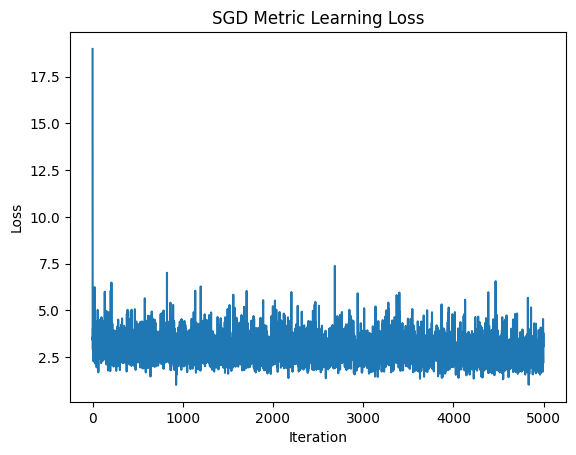

In [18]:
start = time.time()
M_learned, loss_history, grad_history, m_history = sgd_metric_learning(
    images_pca_normalized,
    labels,
    M,
    learning_rate,
    n_iters,
    initial_batch_size,
    b,
    print_every=100,
)
end = time.time()
print(f"Time taken: {end - start} seconds")

# Plot the loss over iterations
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("SGD Metric Learning Loss")
plt.show()

In [22]:
m_history[1000:]

[array([[2.45737639, 0.52688592, 0.47281517, ..., 0.78045946, 0.48459695,
         0.8019289 ],
        [0.52688592, 2.59562961, 0.51942334, ..., 0.41077531, 0.55639191,
         0.76209299],
        [0.47281517, 0.51942334, 2.06032456, ..., 0.25048589, 0.7855004 ,
         0.48631212],
        ...,
        [0.78045946, 0.41077531, 0.25048589, ..., 2.08488671, 0.23538955,
         0.43561386],
        [0.48459695, 0.55639191, 0.7855004 , ..., 0.23538955, 2.00823322,
         0.71646261],
        [0.8019289 , 0.76209299, 0.48631212, ..., 0.43561386, 0.71646261,
         2.24204668]]),
 array([[2.45772051, 0.5263438 , 0.47247065, ..., 0.78041712, 0.48460845,
         0.80192851],
        [0.5263438 , 2.59570985, 0.51926311, ..., 0.41076893, 0.55641236,
         0.76205338],
        [0.47247065, 0.51926311, 2.06013624, ..., 0.25055309, 0.7854589 ,
         0.48635112],
        ...,
        [0.78041712, 0.41076893, 0.25055309, ..., 2.08489218, 0.23538532,
         0.43561584],
        [0.4

x -> M^{1/2}x

Distance metric learning with application to clustering with side information

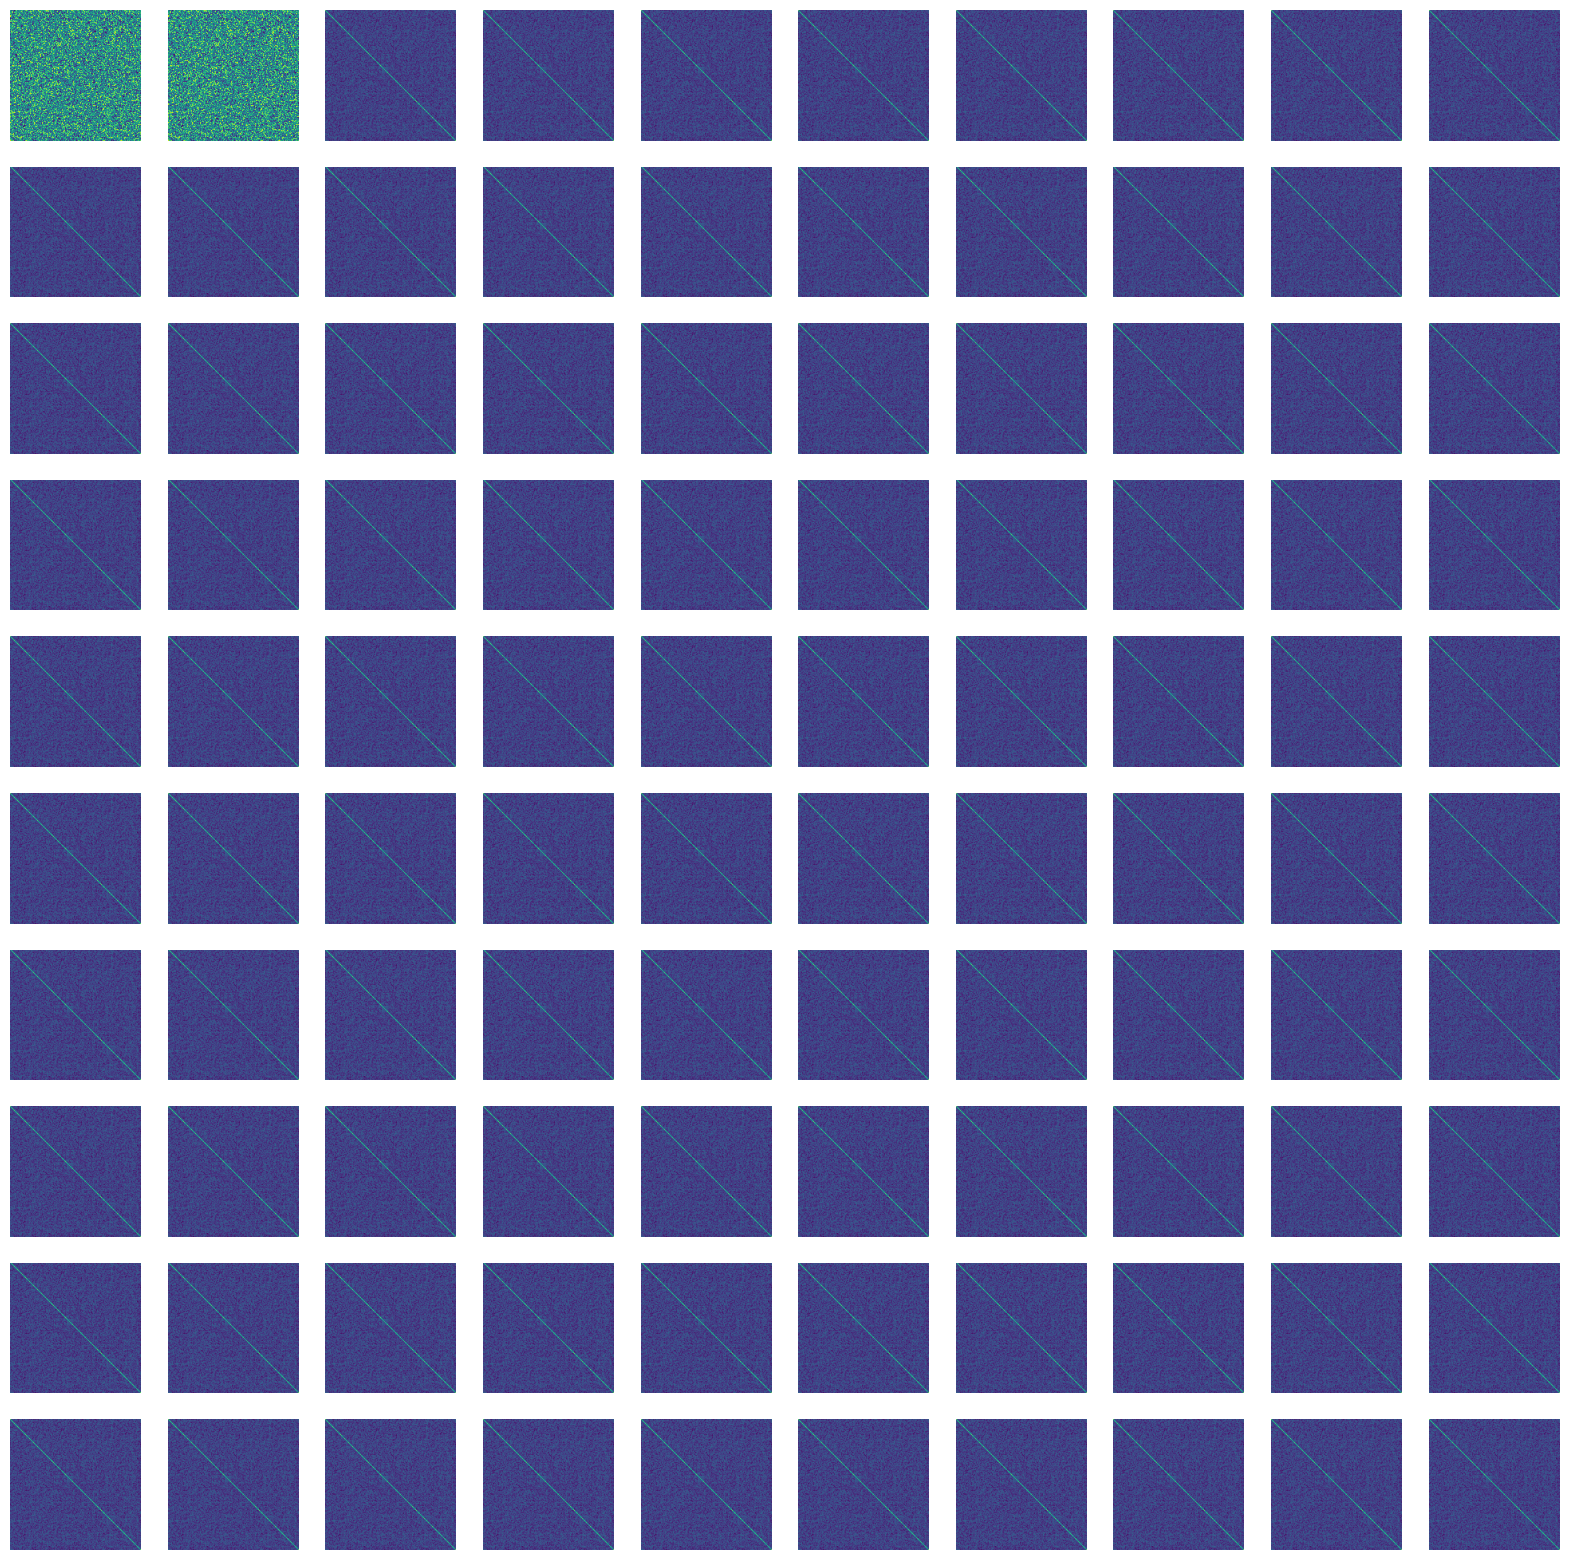

In [19]:
fig, ax = plt.subplots(len(m_history[:100]) // 10, 10, figsize=(20, 20))

for i, m in enumerate(m_history[:100]):  # Limit to the first 100 items
    ax[i // 10, i % 10].imshow(m)
    ax[i // 10, i % 10].axis("off")

plt.show()